### Author : Gautham Botlaguduru
### Date : 19th Dec 2023

# IRIS 

### Imports

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### Global variables

In [2]:
'''
Set global variables
'''
testSize = 0.15
randomState = 1

### Load Iris Data and Targets

In [3]:
'''
Load dataset from sklearn to get training data and target data
Shuffle dataset
Form Dictionary for outputs
'''

iris = datasets.load_iris()

irisData = pd.DataFrame(iris['data'], columns = iris['feature_names'])
irisTargets = pd.DataFrame(iris['target'], columns = ['target'])
targetDict = dict(zip(list(irisTargets['target'].unique()), list(iris['target_names'])))

irisData, irisTargets = shuffle(irisData, irisTargets, random_state = randomState)

display(irisData.head())
display(irisTargets.head())
print('Shape: ', irisData.shape, irisTargets.shape)
print('Target Dictionary: ', targetDict)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
14,5.8,4.0,1.2,0.2
98,5.1,2.5,3.0,1.1
75,6.6,3.0,4.4,1.4
16,5.4,3.9,1.3,0.4
131,7.9,3.8,6.4,2.0


,target
14,0
98,1
75,1
16,0
131,2


Shape:  (150, 4) (150, 1)
Target Dictionary:  {0: 'setosa', 1: 'versicolor', 2: 'virginica'}


### Split data into train and test

In [4]:
'''
Split data into train and test sets
'''

trainData, testData, trainTarget, testTarget = train_test_split(irisData, irisTargets, 
                                                    test_size = testSize, random_state = randomState)
print(trainData.shape, testData.shape, trainTarget.shape, testTarget.shape)

(127, 4) (23, 4) (127, 1) (23, 1)


In [5]:
'''
Check if dataset has any imbalance among the categories.
There does not seem to be any major imbalance.
So no need of applying any undersampling or oversampling methods.
'''

trainTarget['target'].value_counts(), testTarget['target'].value_counts()

(target
 0    44
 1    42
 2    41
 Name: count, dtype: int64,
 target
 2    9
 1    8
 0    6
 Name: count, dtype: int64)

## EDA

### NaN count in training

In [6]:
print(trainData.isna().sum().sum())

0


In [7]:
'''
Medians will be used to impute NaN values in testing, if there a need for imputation
no nans in training but would have imputed with nans as well
'''

medians = trainData.median()
medians

sepal length (cm)    5.7
sepal width (cm)     3.0
petal length (cm)    4.3
petal width (cm)     1.3
dtype: float64

In [8]:
'''
Get basic summary stats of dataset
'''
summaryStats = trainData.describe()
summaryStats

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,127.000000,127.000000,127.000000,127.000000
mean,5.818898,3.079528,3.704724,1.182677
std,0.803932,0.437587,1.758149,0.764292
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.700000,3.000000,4.300000,1.300000
75%,6.400000,3.400000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Histograms

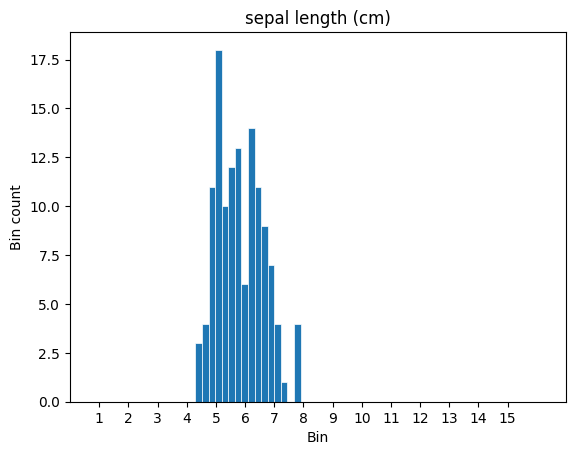

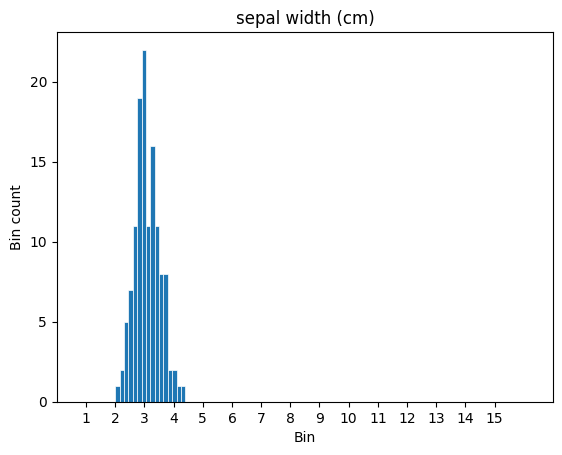

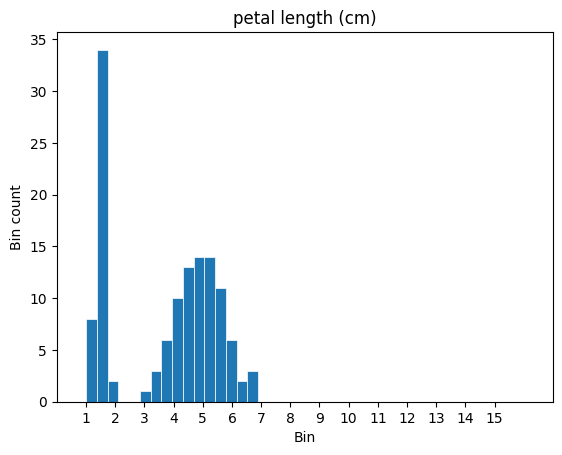

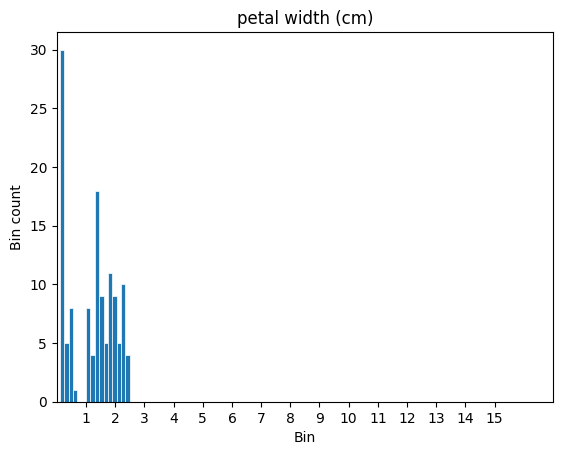

In [9]:
'''
Plotted the histogram to get a visual understanding of underlying distribution.
We can apply some kernel methods to assign suitable distributions.
We can observe that petal width and petal length are a mixture of distributions.
Let's use a pair plot to see if the mixture can be analysed into categories.
'''
for variable in trainData.columns:

    fig, ax = plt.subplots()
    
    x = trainData[variable].to_list()
    numBins = int(1 + 3.22*(math.log(trainData.shape[0])))

    ax.hist(x, bins = numBins, linewidth=0.5, edgecolor="white")
    ax.set(xlim = (0, numBins + 1), xticks=np.arange(1, numBins))
    plt.title(variable)
    plt.xlabel('Bin')
    plt.ylabel('Bin count')
    plt.show()

### Pair Plot

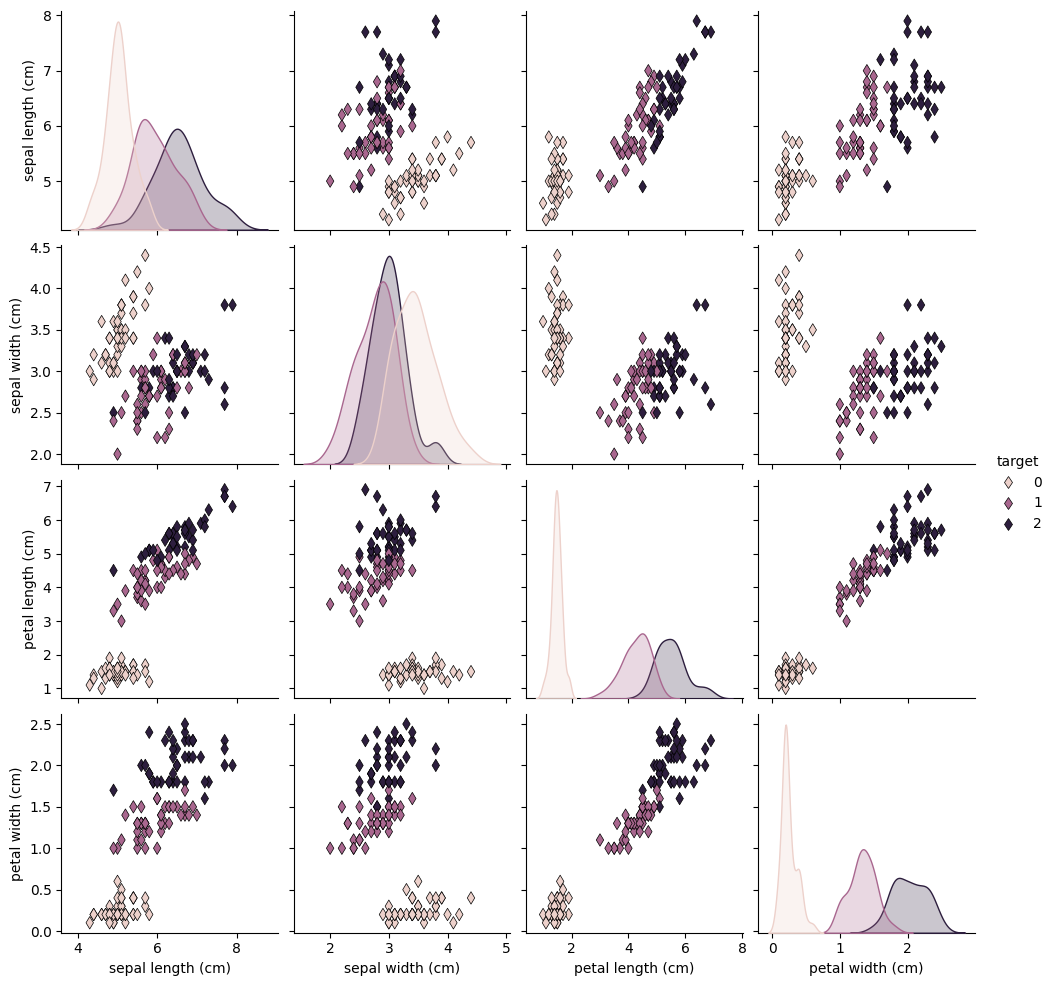

In [10]:
'''
Pair plots to understand relationships amongst variables under each target category
It can be observed that petal width and length can probably be a deciding factor to classify class 0 (setosa)

'''

plotData = pd.merge(trainData, trainTarget, left_index = True, right_index = True)
sns.pairplot(plotData, hue='target', markers='d', height=2.5, plot_kws=
    {
    "s":40,
    "alpha":1.0,
    'lw':0.5,
    'edgecolor':'k'
    })

### Box Plot

<Axes: >

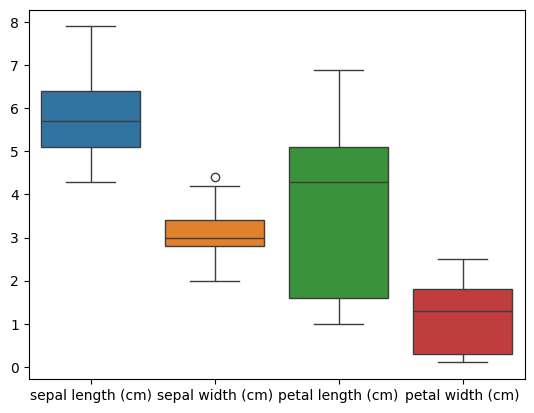

In [11]:
'''
Box plot to get visual understanding of IQR, median and any outliers

It can be observed that:
1. there is 1 outlier for sepal width.
2. Medians for petal lengths and petal widths are close to the 3rd quartile.

'''
sns.boxplot(trainData)

In [12]:
'''
Since there are only 150 observations (of which we are using only 127 for training),
let us try to do some basic feature engineering and drop highly correlated features.

The function below will return a dataset with selected variables whoe correlation is within the threshold
It will also return a correlation table to show what was selected and what was dropped.

The default threshold has been set to 0.9
'''

def corrBasedElimination(data, correlationThreshold = 0.9):
    
    correlatedPairs = pd.DataFrame(columns = ['selected', 'dropped', 'correlation value'])
    corr_mat = data.corr(method = 'pearson').abs()
    corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape)).astype(np.bool_))
    np.fill_diagonal(corr_mat.values, np.nan)
    keep = list(corr_mat.index)
    corr_mat['cols'] = corr_mat.index
    i = 0
    le = len(keep)
    while i < le:
        temp = corr_mat[corr_mat['cols'] == keep[i]]
        temp = temp.drop(columns = ['cols'])
        temp = pd.Series(temp.iloc[0, :])
        temp = temp[temp >= correlationThreshold]
        dropped = list(set(list(temp.index)))
        row = pd.DataFrame({'selected' : len(dropped)*[keep[i]],
               'dropped' : dropped,
               'correlation value': list(temp)})
        correlatedPairs = pd.concat([correlatedPairs, row])
        diff = list(set(keep) - set(list(temp.index)))
        keep = [item for item in keep if item in diff]
        le = len(keep)
        i += 1

    data = data[keep]
    return [data, correlatedPairs]

In [13]:
'''
Petal length and petal width are highly correlated.
Petal width was dropped.
'''

display(trainData.corr())

[engTrainData, correlatedSelections] = corrBasedElimination(trainData)
display(engTrainData)
print(correlatedSelections)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.145308,0.866172,0.810025
sepal width (cm),-0.145308,1.000000,-0.467495,-0.411368
petal length (cm),0.866172,-0.467495,1.000000,0.963908
petal width (cm),0.810025,-0.411368,0.963908,1.000000


/var/folders/cq/f1x6ty5x23z59lx_6lwskc340000gn/T/ipykernel_79568/3449233683.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlatedPairs = pd.concat([correlatedPairs, row])


,sepal length (cm),sepal width (cm),petal length (cm)
112,6.8,3.0,5.5
81,5.5,2.4,3.7
64,5.6,2.9,3.6
128,6.4,2.8,5.6
35,5.0,3.2,1.2
...,...,...,...
7,5.0,3.4,1.5
50,7.0,3.2,4.7
138,6.0,3.0,4.8
25,5.0,3.0,1.6


            selected           dropped  correlation value
0  petal length (cm)  petal width (cm)           0.963908


In [14]:
'''
Let us try to build a support vector classifier with default parameters.
An SVC was a good choice because we saw that petal lenth (and width were good starting points to separate setosa
from the other two classes.
'''

model = SVC(random_state = randomState)
model.fit(trainData, trainTarget)

/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(random_state=1)

In [15]:
'''
The classification report gives promising results for each class.
'''

basicTrainPreds = model.predict(trainData)
print(confusion_matrix(trainTarget['target'], basicTrainPreds))
print(classification_report(trainTarget['target'], basicTrainPreds))

[[44  0  0]
 [ 0 40  2]
 [ 0  2 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.95      0.95      0.95        42
           2       0.95      0.95      0.95        41

    accuracy                           0.97       127
   macro avg       0.97      0.97      0.97       127
weighted avg       0.97      0.97      0.97       127



In [16]:
'''
We will now do a grid search for best parameters.
We will fix random_state and probability (to get auc scores)

Also since the dataset is small, we will limit our CV to 3 fold.
We will focus on F1 optimization

'''

param_grid = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid = GridSearchCV(estimator = SVC(), 
                    param_grid=param_grid, 
                    scoring = 'f1',
                    cv=3, verbose=1, refit = True)
grid.fit(trainData, trainTarget)

/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X,

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **sc

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1', verbose=1)

In [17]:
'''
Results of the grid search
'''

svcParams = grid.best_params_
svcParams['random_state'] = randomState
svcParams['probability'] = True
print(grid.best_estimator_)

SVC(C=0.1, kernel='linear')


In [18]:
'''
We will then build a tuned model with 3 fold cross validation and compute scores (accuracy).
'''
tunedModel = SVC(**svcParams)
print('cross validation scores', cross_val_score(tunedModel, trainData, trainTarget, cv = 3))
tunedModel.fit(trainData, trainTarget)

cross validation scores [0.93023256 0.97619048 0.97619048]


/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gautham/anaconda3/envs/quakerProject/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataC

SVC(C=0.1, kernel='linear', probability=True, random_state=1)

In [19]:
'''
Model performance on training data is good
'''
trainPreds = tunedModel.predict(trainData)

print('Confusion matrix: ', confusion_matrix(trainTarget['target'], trainPreds))
print('Classification report: ', classification_report(trainTarget['target'], trainPreds))
print('Accuracy: ', accuracy_score(trainTarget['target'], trainPreds))
print('AUC score: ', roc_auc_score(np.array(trainTarget['target']), tunedModel.predict_proba(trainData),
                    multi_class='ovr'))

Confusion matrix:  [[44  0  0]
 [ 0 40  2]
 [ 0  2 39]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.95      0.95      0.95        42
           2       0.95      0.95      0.95        41

    accuracy                           0.97       127
   macro avg       0.97      0.97      0.97       127
weighted avg       0.97      0.97      0.97       127

Accuracy:  0.968503937007874
AUC score:  0.9977451218717777


In [20]:
'''
Model performance on test data (not seen during data)
A good performance here also indicates that there is NO overfitting.
'''

testPreds = tunedModel.predict(testData)
print('Confusion matrix: ', confusion_matrix(testTarget['target'], testPreds))
print('Classification report: ', classification_report(testTarget['target'], testPreds))
print('Accuracy: ', accuracy_score(testTarget['target'], testPreds))
print('AUC score: ', roc_auc_score(np.array(testTarget['target']), tunedModel.predict_proba(testData),
                    multi_class='ovr'))

Confusion matrix:  [[6 0 0]
 [0 8 0]
 [0 2 7]]
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         8
           2       1.00      0.78      0.88         9

    accuracy                           0.91        23
   macro avg       0.93      0.93      0.92        23
weighted avg       0.93      0.91      0.91        23

Accuracy:  0.9130434782608695
AUC score:  1.0
